In [1]:
%matplotlib inline

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

# import scipy.stats as stats
# import scipy.signal as sig

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [2]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [3]:
size = 0

def logToPositions(filename):
    global size
    file = open(filename)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('#CLI: Heh, heh, heh... what a mess!'):
            raise Exception('There was an error in the execution of this protocol ' + filename)
        elif line.startswith('#'):
            positions = line[1:].strip().split(',')[:-1]
            if (size == 0):
                size=len(positions)
            for p in positions:
                yield int(p)
    if not found_christmas:
        print('WARNING! Logs may not be complete for ' + filename)

In [4]:
def loadAllPositions(base, N):
    for i in range(1,N+1):
        positions = logToPositions(base+str(i)+'.log')
        yield positions

WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/static/nodejs1.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/dynamic/nodejs1.log


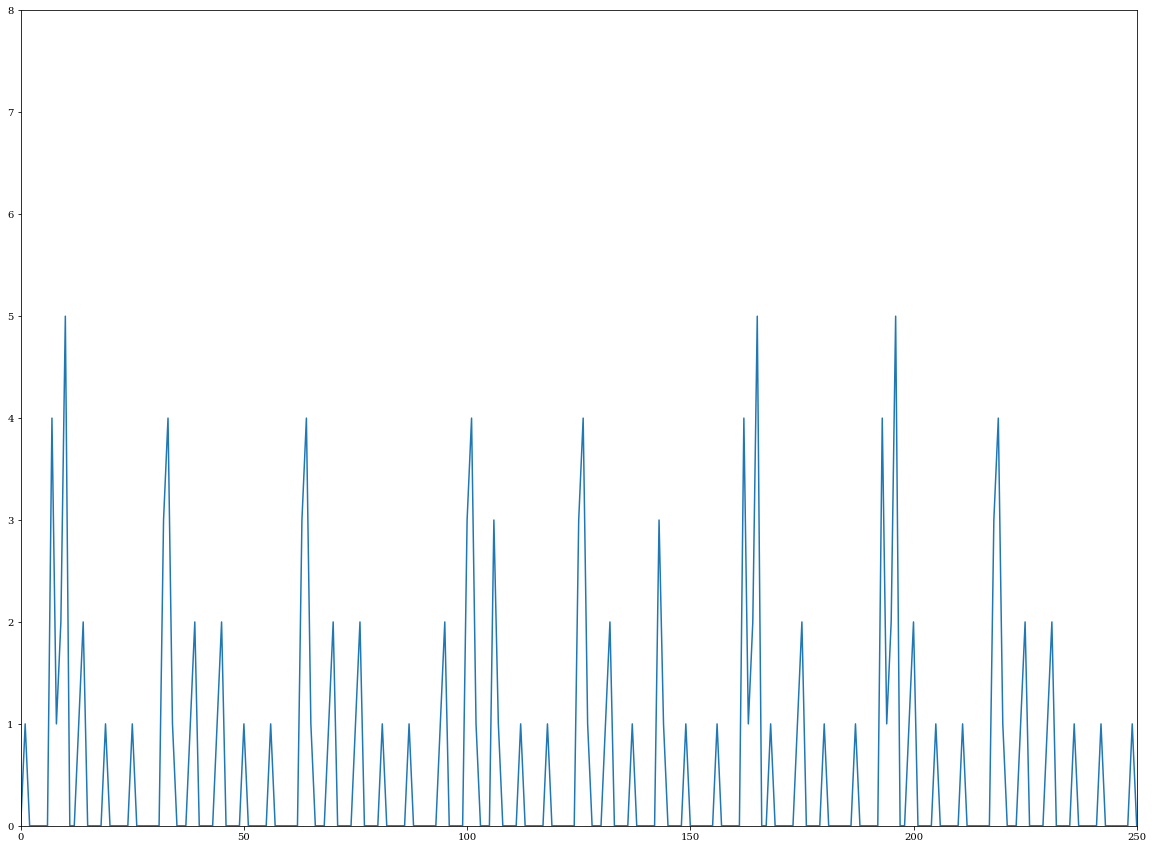

In [5]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'
N = 25

base_positionsClient = list(loadAllPositions(base_dir+'base/nodejs',N))
static_positionsClient = list(loadAllPositions(base_dir+'static/nodejs',N))
runtime_positionsClient = list(loadAllPositions(base_dir+'dynamic/nodejs',N))

base_data = np.array(list(base_positionsClient[0]))
static_data = np.array(list(static_positionsClient[0]))
runtime_data = np.array(list(runtime_positionsClient[0]))

plt.figure(1, figsize=(20,15))
# plt.plot(base_data)
# plt.plot(static_data)
plt.plot(runtime_data)
plt.xlim((0,250))
plt.ylim((0,8))
plt.show()

(1864,)
(919,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


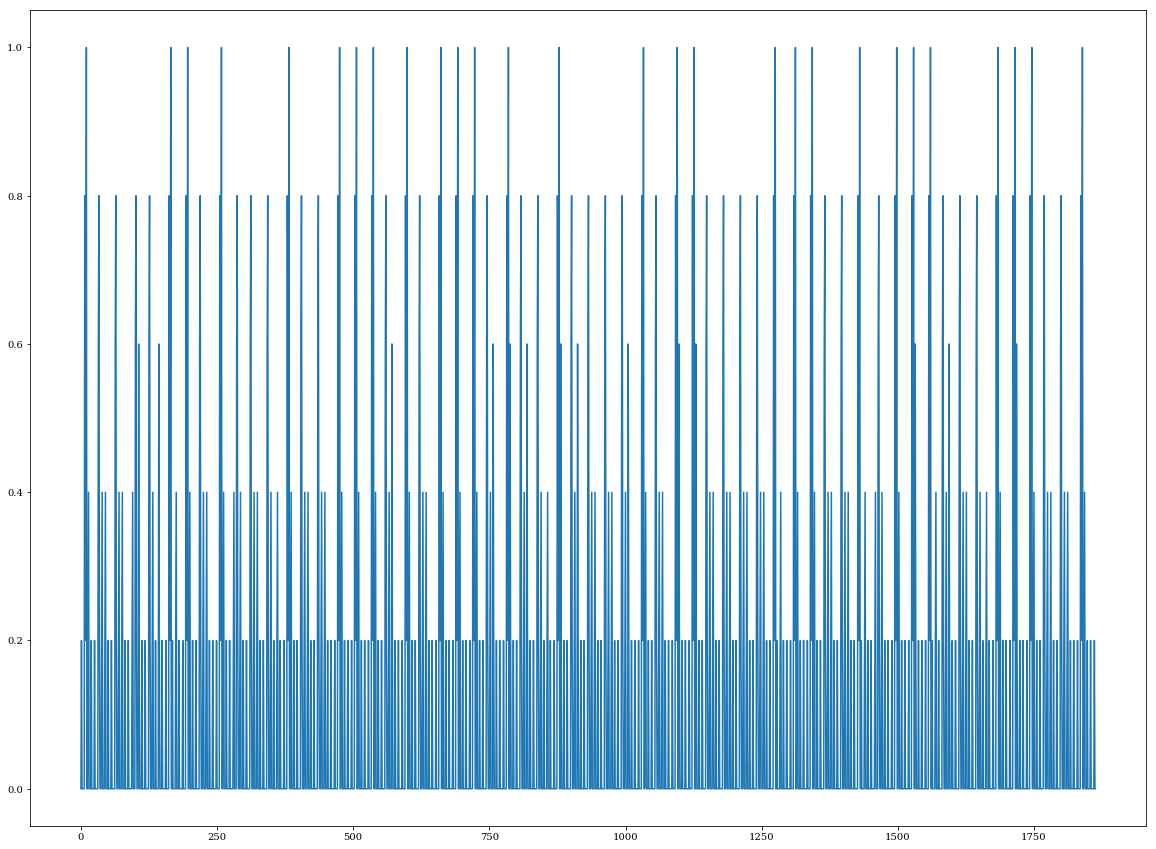

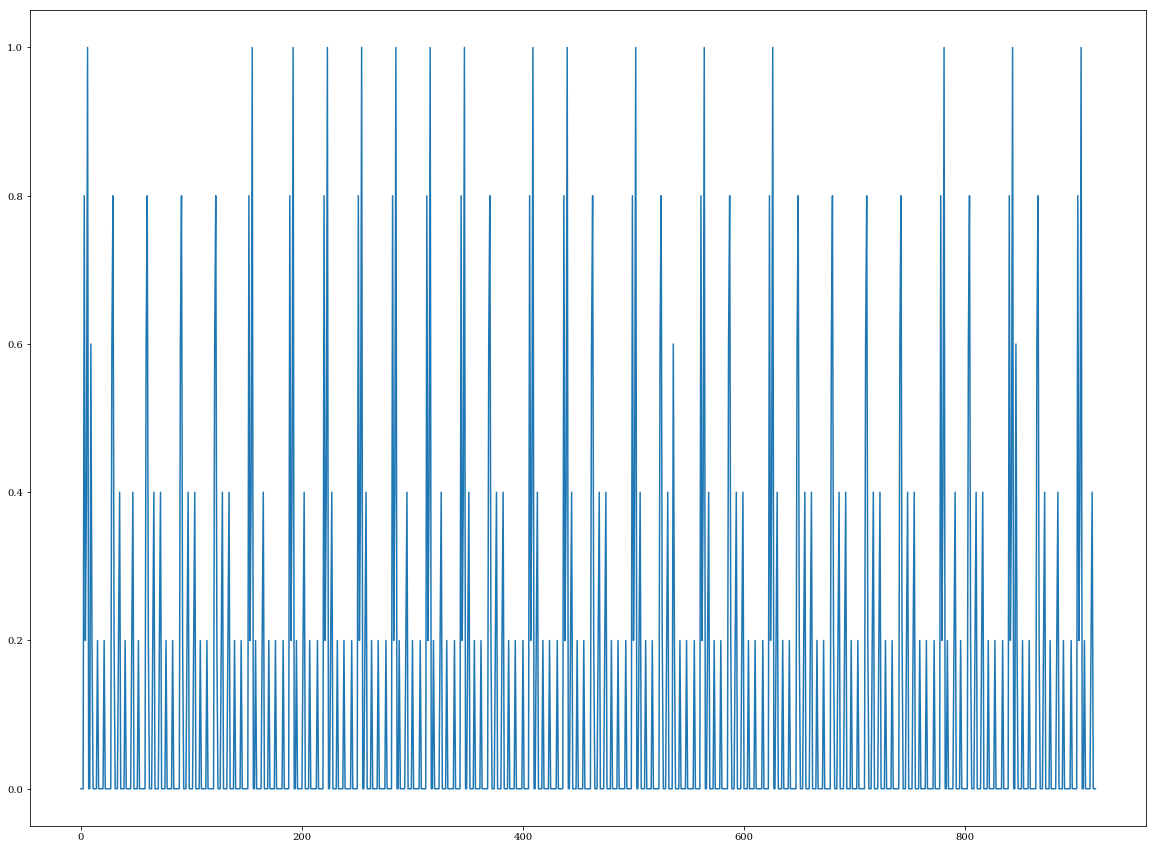

In [54]:
seq = 0
dataset = np.array(runtime_data)
# indexes = np.arange(len(dataset))
# indexed = np.vstack((indexes, dataset)).T
# print(indexed.shape)

train_ratio = 0.67
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
train = np.array(train)
test = np.array(test)
print(train.shape)
print(test.shape)

#Scale data to fit into y=[0,1]
train = MinMaxScaler().fit_transform(train.reshape(-1, 1))
test = MinMaxScaler().fit_transform(test.reshape(-1, 1))

plt.figure(2, figsize=(20,15))
plt.plot(train)
#plt.xlim((0,250))
#plt.ylim((-1,3))
plt.show()

plt.figure(3, figsize=(20,15))
plt.plot(test)
#plt.xlim((0,250))
#plt.ylim((-1,3))
plt.show()

In [55]:
"""
See https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
print(test.shape)
print(train.shape)
# print(test)
# print(train)

train = series_to_supervised(list(train), 18, 1)
test = series_to_supervised(list(test), 18, 1)

print(test.shape)
print(train.shape)
# print(test)
# print(train)

(919, 1)
(1864, 1)
(901, 19)
(1846, 19)


In [59]:
#train_X = np.reshape(train, (train.shape[0], 1, train.shape[1]))
#test_X = np.reshape(test, (test.shape[0], 1, test.shape[1]))

train_X = np.array(train.iloc[:,0:-1])
train_Y = np.array(train.iloc[:,-1])
test_X = np.array(test.iloc[:,0:-1])
test_Y = np.array(test.iloc[:,-1])

train_Y = np.reshape(train_Y, (train_Y.shape[0],1))
test_Y = np.reshape(test_Y, (test_Y.shape[0],1))

n = train_X.shape[0]
L = 3
X_train_seq = []
Y_train_seq = []
for k in range(n - L + 1):
    X_train_seq.append(train_X[k : k + L])
    Y_train_seq.append(train_Y[k : k + L])

train_X = np.array(X_train_seq)
train_Y = np.array(Y_train_seq)

print

#FIXME: make a function
n = test_X.shape[0]
L = 3
X_test_seq = []
Y_test_seq = []
for k in range(n - L + 1):
    X_test_seq.append(test_X[k : k + L])
    Y_test_seq.append(test_Y[k : k + L])

test_X = np.array(X_test_seq)
test_Y = np.array(Y_test_seq)


model = keras.Sequential()
#model.add(keras.layers.LSTM(1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(1, return_sequences=True))
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

 
model.compile(loss="mse", optimizer="adam")

model.fit(train_X, train_Y, batch_size=16, epochs=25, verbose=2)
result = model.evaluate(test_X, test_Y)
print(result)

Epoch 1/25
 - 4s - loss: 0.0488
Epoch 2/25
 - 0s - loss: 0.0423
Epoch 3/25
 - 0s - loss: 0.0374
Epoch 4/25
 - 0s - loss: 0.0332
Epoch 5/25
 - 0s - loss: 0.0287
Epoch 6/25
 - 0s - loss: 0.0244
Epoch 7/25
 - 0s - loss: 0.0217
Epoch 8/25
 - 0s - loss: 0.0196
Epoch 9/25
 - 0s - loss: 0.0181
Epoch 10/25
 - 0s - loss: 0.0166
Epoch 11/25
 - 0s - loss: 0.0156
Epoch 12/25
 - 0s - loss: 0.0147
Epoch 13/25
 - 0s - loss: 0.0137
Epoch 14/25
 - 0s - loss: 0.0131
Epoch 15/25
 - 0s - loss: 0.0124
Epoch 16/25
 - 0s - loss: 0.0118
Epoch 17/25
 - 0s - loss: 0.0115
Epoch 18/25
 - 0s - loss: 0.0110
Epoch 19/25
 - 0s - loss: 0.0105
Epoch 20/25
 - 0s - loss: 0.0102
Epoch 21/25
 - 0s - loss: 0.0098
Epoch 22/25
 - 0s - loss: 0.0096
Epoch 23/25
 - 0s - loss: 0.0093
Epoch 24/25
 - 0s - loss: 0.0091
Epoch 25/25
 - 0s - loss: 0.0088
899/899 [==============================] - 1s 1ms/step
0.0101647757541


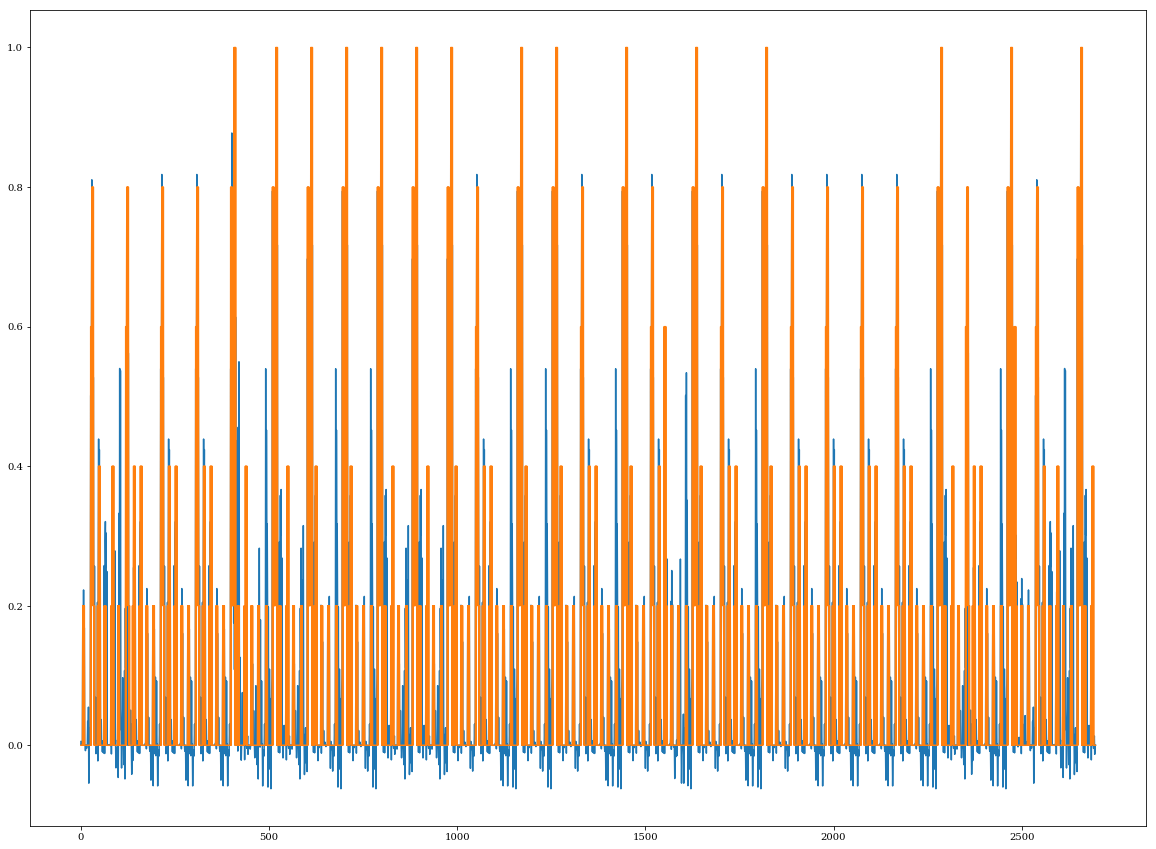

In [57]:
predictions = model.predict(test_X)
plt.figure(4, figsize=(20,15))
plt.plot(predictions.flatten())
plt.plot(test_Y.flatten())
#plt.xlim((0,250))
#plt.ylim((-1,3))
plt.show()